In [627]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio as rio
from rasterio import features
from rasterio.windows import Window
import matplotlib.pyplot as plt
import numpy as np
import pprint as pp
import itertools as it


In [2]:
from rasterio.plot import show
from rasterio.warp import transform

xs = np.array([3327493.433, 16177493.43])
ys = np.array([7389201.61, -580798.392])

lossyear = 'data/Hansen_GFC-2022-v1.10_lossyear_50N_000E.tif'
datamask = 'data/Hansen_GFC-2022-v1.10_datamask_50N_000E.tif'
foo = 'data/TCL_DD_2022_20230407.tif'

src = rio.open(foo)
band = src.read(1)



In [3]:
mask = band != 12
shapes = features.shapes(band, mask=mask, transform=src.transform)
pp.pprint(next(shapes)) # first element
    

<class 'rasterio.io.DatasetReader'>
<class 'numpy.ndarray'>
({'coordinates': [[(1.4645000000000001, 50.0),
                   (1.4645000000000001, 49.99975),
                   (1.46525, 49.99975),
                   (1.46525, 49.9995),
                   (1.4655, 49.9995),
                   (1.4655, 50.0),
                   (1.4645000000000001, 50.0)]],
  'type': 'Polygon'},
 5.0)


({'coordinates': [[(1.4645000000000001, 50.0),
                   (1.4645000000000001, 49.99975),
                   (1.46525, 49.99975),
                   (1.46525, 49.9995),
                   (1.4655, 49.9995),
                   (1.4655, 50.0),
                   (1.4645000000000001, 50.0)]],
  'type': 'Polygon'},
 5.0)

In [97]:
# rasterio.features.dataset_features # works on raster value rather than mask...

with rio.open('data/TCL_DD_2022_20230407.tif') as src:
    # TODO: check src.count for number of bands...
    print(src.meta)
    band = src.read(1)
    mask = band == 1
    # Object holding a feature collection that implements the __geo_interface__
    # TODO: result should be in EPSG 4326 i.e. GPS
    results = (
        {'properties': {'deforestation': v}, 'geometry': s}
        for i, (s, v) in enumerate(
            features.shapes(band, mask=mask)
            )
        )
    geoms=list(results)
    gdf = gpd.GeoDataFrame.from_features(geoms)
    
gdf.head()


{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 15.0, 'width': 4008, 'height': 1737, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS_1984_Goode_Homolosine",GEOGCS["GCS_unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Interrupted_Goode_Homolosine"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(9999.999999999984, 0.0, -20037506.5671,
       0.0, -9999.999999999984, 8686794.97909997)}


,geometry,deforestation
0,"POLYGON ((2336.000 213.000, 2336.000 214.000, ...",1.0
1,"POLYGON ((2337.000 217.000, 2337.000 218.000, ...",1.0
2,"POLYGON ((514.000 223.000, 514.000 224.000, 51...",1.0
3,"POLYGON ((2339.000 224.000, 2339.000 225.000, ...",1.0
4,"POLYGON ((516.000 225.000, 516.000 226.000, 51...",1.0


geometry	deforestation
0	POLYGON ((2870.000 104.000, 2870.000 105.000, ...	4.0
1	POLYGON ((2777.000 110.000, 2777.000 111.000, ...	4.0
2	POLYGON ((2778.000 111.000, 2778.000 112.000, ...	4.0
3	POLYGON ((2730.000 113.000, 2730.000 114.000, ...	4.0
4	POLYGON ((2737.000 113.000, 2737.000 114.000, ...	4.0

In [715]:
# rasterio.features.dataset_features # works on raster value rather than mask...

with rio.open('data/Hansen_GFC-2022-v1.10_lossyear_20S_060W.tif') as src:
    # TODO: check src.count for number of bands...
    print(src.meta)
    band = src.read(1, window=Window(2100, 2000, 50, 50))
    print(band.shape)
    rdf = gpd.GeoDataFrame()
    mask = band != 0
    # Object holding a feature collection that implements the __geo_interface__
    # TODO: result should be in EPSG 4326 i.e. GPS
    results = (
        {'properties': {'lossyear': v}, 'geometry': s}
        for i, (s, v) in enumerate(
            # connectivity, 4 on edges, 8 on edges and corners...
            features.shapes(band, mask=mask, connectivity=8)
            )
        )
    geoms=list(results)
    gdf = gpd.GeoDataFrame.from_features(geoms)
    rdf = gpd.GeoDataFrame( pd.concat( [rdf, gdf], ignore_index=True), crs=gdf.crs)

rdf.head()


{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 40000, 'height': 40000, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00025, 0.0, -60.0,
       0.0, -0.00025, -20.0)}
(50, 50)


,geometry,lossyear
0,"POLYGON ((0.00000 0.00000, 0.00000 3.00000, 4....",22.0
1,"POLYGON ((32.00000 0.00000, 32.00000 3.00000, ...",22.0
2,"POLYGON ((43.00000 3.00000, 43.00000 4.00000, ...",10.0
3,"POLYGON ((28.00000 4.00000, 28.00000 5.00000, ...",22.0
4,"POLYGON ((0.00000 5.00000, 0.00000 8.00000, 5....",10.0


In [710]:
rdf.tail() # 175761 polygons for 10% of original over 22 years...
rdf.shape

(174, 2)

<Axes: >

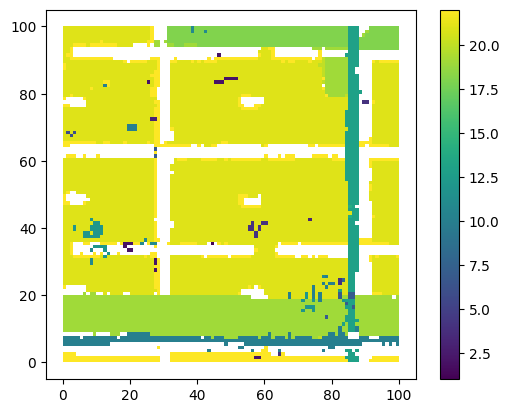

In [711]:
rdf.plot(column='lossyear', legend=True)

In [781]:
# sjoin does not modify the geometry...
intersects = rdf.sjoin(rdf, how="left", predicate="intersects")
intersects.shape, intersects.index.value_counts()

((139, 4),
 36    25
 37     6
 27     5
 13     5
 11     5
 19     5
 5      5
 8      4
 25     4
 24     4
 26     4
 18     4
 7      3
 9      3
 23     3
 33     3
 22     3
 17     3
 10     3
 30     2
 20     2
 31     2
 32     2
 29     2
 35     2
 38     2
 39     2
 34     2
 40     2
 28     2
 21     2
 1      2
 16     2
 15     2
 14     2
 12     2
 6      2
 4      2
 2      2
 3      1
 0      1
 Name: count, dtype: int64)

In [782]:
intersects.reset_index(inplace=True)
intersects.rename(columns={'index': 'index_left'}, inplace=True)
#intersects['lossyear_left'] = intersects['lossyear_left'].astype(int) + 2000
#intersects['lossyear_right'] = intersects['lossyear_right'].astype(int) + 2000
intersects.head(200)


,index_left,geometry,lossyear_left,index_right,lossyear_right
0,0,"POLYGON ((0.00000 0.00000, 0.00000 3.00000, 4....",22.0,0,22.0
1,1,"POLYGON ((32.00000 0.00000, 32.00000 3.00000, ...",22.0,1,22.0
2,1,"POLYGON ((32.00000 0.00000, 32.00000 3.00000, ...",22.0,2,10.0
3,2,"POLYGON ((43.00000 3.00000, 43.00000 4.00000, ...",10.0,1,22.0
4,2,"POLYGON ((43.00000 3.00000, 43.00000 4.00000, ...",10.0,2,10.0
...,...,...,...,...,...
134,38,"POLYGON ((27.00000 43.00000, 27.00000 50.00000...",22.0,38,22.0
135,39,"POLYGON ((0.00000 47.00000, 0.00000 50.00000, ...",22.0,36,21.0
136,39,"POLYGON ((0.00000 47.00000, 0.00000 50.00000, ...",22.0,39,22.0
137,40,"POLYGON ((6.00000 47.00000, 6.00000 48.00000, ...",22.0,36,21.0


In [795]:
# TODO: it seems that it is not unique over group_id and lossyear but rather
# the index_right is an additional level...


# geometry is then union of those belonging to same 'group'
# 'index_left' and 'index_right' still reference original geometry in 'rdf'
# grab the original geometry and replace the union values...
temp = intersects.dissolve(
    "index_right",
    aggfunc=lambda x: x.tolist(),
)
temp.reset_index(inplace=True)
temp['geometry'] = rdf['geometry']
temp['lossyear'] = rdf['lossyear'].astype(int) + 2000

groupId = 'group_id'
temp[groupId] = None
for i in range(len(temp)): # presume reset_index...
    if temp.loc[i, groupId] is None:
        temp.loc[i, groupId] = i
    id = temp.loc[i, groupId]
    temp.loc[temp["index_left"].apply(lambda x: i in x), groupId] = id

group_ids = temp['group_id'].unique()
lossyears = range(2001, 2002)
#temp.drop(['index_right', 'index_left', 'lossyear_left', 'lossyear_right'], axis=1, inplace=True)
#print(group_ids)
#print(lossyears)
temp.set_index(['group_id', 'lossyear'], inplace=True)#.sort_values(['group_id', 'lossyear'])
#print(temp.columns)
#print(temp.head())
#temp.drop_duplicates()
#pp.pprint(list(it.product(group_ids, lossyears)))
index = pd.MultiIndex.from_tuples(tuples=it.product(group_ids, lossyears), names=('group_id', 'lossyear'))
#print(index)
#temp = temp.reindex(index) # cannot handle a non-unique multi-index!

temp



index_right  \
group_id lossyear                
0        2022                0   
1        2022                1   
         2010                2   
3        2022                3   
4        2010                4   
35       2019                5   
         2022                6   
         2002                7   
4        2021                8   
35       2011                9   
         2002               10   
         2022               11   
         2022               12   
         2022               13   
4        2022               14   
         2022               15   
35       2022               16   
9        2011               17   
35       2002               18   
         2012               19   
18       2022               20   
35       2022               21   
         2022               22   
         2022               23   
         2022               24   
         2011               25   
         2022               26   
         2011               27   
32       2022               28   
         2022               29   
         2001               30   
         2022               31   
         2022               32   
35       2022               33   
         2012               34   
         2012               35   
         2021               36   
32       2021               37   
35       2022               38   
         2022               39   
         2022               40   

                                                            geometry  \
group_id lossyear                                                      
0        2022      POLYGON ((0.00000 0.00000, 0.00000 3.00000, 4....   
1        2022      POLYGON ((32.00000 0.00000, 32.00000 3.00000, ...   
         2010      POLYGON ((43.00000 3.00000, 43.00000 4.00000, ...   
3        2022      POLYGON ((28.00000 4.00000, 28.00000 5.00000, ...   
4        2010      POLYGON ((0.00000 5.00000, 0.00000 8.00000, 5....   
35       2019      POLYGON ((44.00000 7.00000, 45.00000 7.00000, ...   
         2022      POLYGON ((0.00000 22.00000, 0.00000 23.00000, ...   
         2002      POLYGON ((27.00000 27.00000, 27.00000 28.00000...   
4        2021      POLYGON ((32.00000 20.00000, 32.00000 32.00000...   
35       2011      POLYGON ((8.00000 29.00000, 8.00000 31.00000, ...   
         2002      POLYGON ((27.00000 29.00000, 27.00000 31.00000...   
         2022      POLYGON ((3.00000 31.00000, 11.00000 31.00000,...   
         2022      POLYGON ((24.00000 31.00000, 24.00000 32.00000...   
         2022      POLYGON ((28.00000 20.00000, 29.00000 20.00000...   
4        2022      POLYGON ((41.00000 31.00000, 41.00000 32.00000...   
         2022      POLYGON ((43.00000 31.00000, 43.00000 32.00000...   
35       2022      POLYGON ((16.00000 32.00000, 16.00000 33.00000...   
9        2011      POLYGON ((8.00000 33.00000, 8.00000 34.00000, ...   
35       2002      POLYGON ((19.00000 33.00000, 21.00000 33.00000...   
         2012      POLYGON ((12.00000 31.00000, 13.00000 31.00000...   
18       2022      POLYGON ((27.00000 34.00000, 27.00000 35.00000...   
35       2022      POLYGON ((6.00000 35.00000, 6.00000 36.00000, ...   
         2022      POLYGON ((11.00000 35.00000, 11.00000 36.00000...   
         2022      POLYGON ((17.00000 35.00000, 17.00000 36.00000...   
         2022      POLYGON ((21.00000 35.00000, 21.00000 36.00000...   
         2011      POLYGON ((23.00000 35.00000, 23.00000 36.00000...   
         2022      POLYGON ((25.00000 35.00000, 25.00000 36.00000...   
         2011      POLYGON ((26.00000 35.00000, 26.00000 36.00000...   
32       2022      POLYGON ((31.00000 35.00000, 31.00000 36.00000...   
         2022      POLYGON ((35.00000 35.00000, 35.00000 36.00000...   
         2001      POLYGON ((44.00000 35.00000, 44.00000 36.00000...   
         2022      POLYGON ((46.00000 35.00000, 46.00000 36.00000...   
         2022      POLYGON ((48.00000 35.00000, 48.00000 36.00000...   
35       2022      POLYGON ((27.0000

In [612]:
# Must be aware of chained indexing as it may call __get_item__ before __set_item__ which will fail on Nan/None etc.
# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

#temp.index.names, temp.index.levels, temp.index.codes
#temp.isna() # shows only rows where at least one column value is set...
#temp.fillna(0)
#temp.loc[(1, 2018), 'geometry'] = None
#temp.loc[(1, 2017), 'index_right'] = 666
#temp.loc[:,].isnull().sum()
#temp.loc[temp.loc[:,].isna(), 'geometry']
#temp.geometry.fillna()
#temp.head()
#temp.loc[1,2019].geometry = None #shapely.geometry.Polygon([])


index_right       1
geometry          2
index_left        2
lossyear_left     2
lossyear_right    2
dtype: int64

In [701]:
temp.loc[temp['geometry'].isna(), 'geometry'] = Polygon([])
temp['area'] = temp.geometry.area
temp['cum_area'] = temp.groupby('group_id').area.cumsum()

for i in group_ids:
    temp.loc[i, 'cum_geometry'] = list(it.accumulate(temp.loc[i, 'geometry'], func=lambda x,y: x.union(y)))
#list(it.accumulate(temp.loc[1, 'geometry'], func=lambda x,y: x.union(y)))
temp.head(30)
temp.to_csv('data/geoply-sample.csv')

321.0

index_right  \
group_id lossyear                
0        2001              NaN   
         2002              NaN   
         2003              NaN   
         2004              NaN   
         2005              NaN   
         2006              NaN   
         2007              NaN   
         2008              NaN   
         2009              NaN   
         2010              NaN   
         2011              NaN   
         2012              NaN   
         2013              NaN   
         2014              NaN   
         2015              NaN   
         2016              NaN   
         2017              NaN   
         2018              NaN   
         2019              NaN   
         2020              NaN   
         2021              NaN   
         2022              0.0   
1        2001              NaN   
         2002              NaN   
         2003              NaN   
         2004              NaN   
         2005              NaN   
         2006              NaN   
         2007              NaN   
         2008              NaN   
         2009              NaN   
         2010              1.0   
         2011              NaN   
         2012              NaN   
         2013              NaN   
         2014              NaN   
         2015              NaN   
         2016              NaN   
         2017              NaN   
         2018              NaN   
         2019              2.0   
         2020              NaN   
         2021              NaN   
         2022              NaN   

                                                            geometry  \
group_id lossyear                                                      
0        2001                                                   None   
         2002                                                   None   
         2003                                                   None   
         2004                                                   None   
         2005                                                   None   
         2006                                                   None   
         2007                                                   None   
         2008                                                   None   
         2009                                                   None   
         2010                                                   None   
         2011                                                   None   
         2012                                                   None   
         2013                                                   None   
         2014                                                   None   
         2015                                                   None   
         2016                                                   None   
         2017                                                   None   
         2018                                                   None   
         2019                                                   None   
         2020                                                   None   
         2021                                                   None   
         2022      POLYGON ((0.00000 0.00000, 0.00000 3.00000, 4....   
1        2001                                                   None   
         2002                                                   None   
         2003                                                   None   
         2004                                                   None   
         2005                                                   None   
         2006                                                   None   
         2007                                                   None   
         2008                                                   None   
         2009                                                   None   
         2010      POLYGON ((0.00000 5.00000, 0.00000 8.00000, 5....   
      

In [407]:
# filter clusters to remove noise... but the area could still be significant depending on scale
#bar = foo.groupby('index_left').filter(lambda x : len(x) > 10)
intersects[intersects.index_left == intersects.index_right]

,index_left,geometry,lossyear_left,index_right,lossyear_right
0,0,"POLYGON ((11.00000 0.00000, 15.00000 0.00000, ...",2019,0,2019
4,1,"POLYGON ((9.00000 6.00000, 9.00000 8.00000, 12...",2010,1,2010
6,2,"POLYGON ((0.00000 0.00000, 7.00000 0.00000, 7....",2008,2,2008
11,3,"POLYGON ((8.00000 8.00000, 12.00000 8.00000, 1...",2019,3,2019


In [408]:
# only dissolve geometry where lossyear_left == lossyear_right
# index_right will be unique per index_left...
# since this is a 'self' join, 
# self intersections are included, and they are bidirectional...
mask = (intersects.lossyear_left == intersects.lossyear_right)
intersects_homogenous = intersects[mask]
#indices = set(intersects_homogenous.index_right)
# self intersections and duplicates are resolved with a 2-way dissolve...
homogenous = intersects_homogenous.dissolve("index_right", aggfunc="min")
homogenous.reset_index(inplace=True)
homogenous = homogenous.dissolve("index_left", aggfunc="min")
homogenous.reset_index(inplace=True)
homogenous['lossyear'] = homogenous['lossyear_left']
homogenous.drop(['index_left', 'index_right', 'lossyear_left', 'lossyear_right'], axis=1, inplace=True)
intersects_heterogeneous = intersects[intersects.lossyear_left != intersects.lossyear_right]
# above will not include any self intersections...
# but may chain to some that have been dissolved as part of the intersects_homogenous...
# TODO: 



#rdf.drop(indices).shape
#foo = gpd.GeoDataFrame(
    #pd.concat([temp, rdf], ignore_index=True), 
    #crs=rdf.crs)

#intersects_homogenous.index_right.value_counts().unique()

<Axes: >

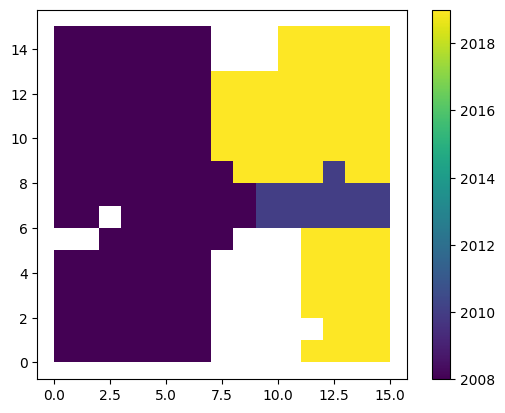

In [410]:
homogenous.plot(column='lossyear', legend=True)

In [382]:
indices_heterogeneous = set(intersects_heterogeneous.index_left)
indices_homogenous = set(intersects_homogenous.index_left)
rdf.shape, homogenous.shape, intersects_heterogeneous.shape
#indices_heterogeneous_left == indices_heterogeneous_right, indices_homogenous_left == indices_homogenous_right
indices_heterogeneous == indices_homogenous
foo = indices_heterogeneous.symmetric_difference(indices_homogenous)
print(foo)
#temp.plot(column='lossyear', legend=True)
#rdf.plot(column='lossyear', legend=True)

{31}


In [192]:
# .touches may not find all neighbours as it excludes .intersects
# 
# remaining .intersects must be ordered by year...
intersects_ = intersects.sjoin(intersects, how="left", predicate="intersects")

((218, 4), (23718, 6))

In [182]:
# there are 737 groupby index_right that have > 1 index_left...
# and 218 groupby index_left that have > 1 index_right...
# does this mean we lose data?
bar.groupby('index_right')['index_left'].count()[lambda x: x>1].count(), bar.groupby('index_left')['index_right'].count()[lambda x: x>1].count()
# no as the geometry is what we need, it does however mean that the index_left and index_right
# can not be relied upon afterwards other than being unique...

(737, 218)

<Axes: >

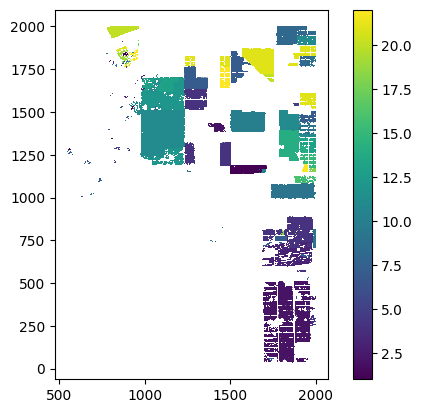

In [122]:
bar_diss.plot(column='lossyear_left', legend=True)

In [ ]:
# .touches can be used to find neighbours...
#   it is a row-wise operator
#   polygons at the edges of the Window/Band may be partial...
# .overlay is much like .sjoin + .dissolve

In [112]:
foo_diss = foo.dissolve("index_right",aggfunc="min")
foo_diss = foo_diss.reset_index().dissolve("index_left",aggfunc="min")

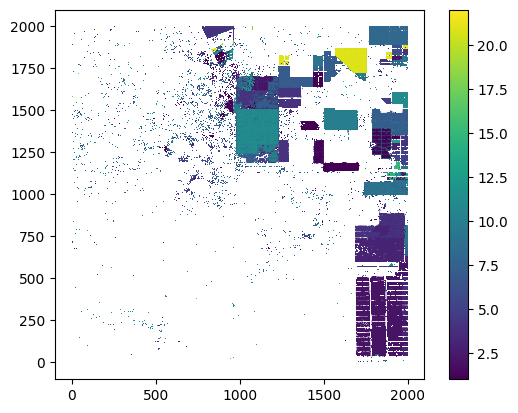

In [113]:
ax = foo_diss.plot(column='lossyear_left', legend=True)

In [115]:
foo_diss.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 36160 entries, 0 to 47520
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   geometry        36160 non-null  geometry
 1   index_right     36160 non-null  int64   
 2   lossyear_left   36160 non-null  int64   
 3   lossyear_right  36160 non-null  int64   
dtypes: geometry(1), int64(3)
memory usage: 2.4 MB


In [107]:
foo.sort_values(['lossyear_left', 'lossyear_right'], axis=0)
# each time series is 

,index_left,geometry,lossyear_left,index_right,lossyear_right
363,231,"POLYGON ((366.000 37.000, 366.000 38.000, 367....",1,231,1
1248,675,"POLYGON ((498.000 103.000, 498.000 104.000, 49...",1,675,1
1249,675,"POLYGON ((498.000 103.000, 498.000 104.000, 49...",1,683,1
1260,683,"POLYGON ((497.000 104.000, 497.000 105.000, 49...",1,675,1
1262,683,"POLYGON ((497.000 104.000, 497.000 105.000, 49...",1,683,1
...,...,...,...,...,...
100430,44773,"POLYGON ((1974.000 1887.000, 1974.000 1888.000...",22,44773,22
100432,44774,"POLYGON ((1983.000 1887.000, 1983.000 1888.000...",22,44774,22
100434,44775,"POLYGON ((1989.000 1887.000, 1989.000 1888.000...",22,44775,22
100436,44776,"POLYGON ((1991.000 1887.000, 1991.000 1888.000...",22,44776,22


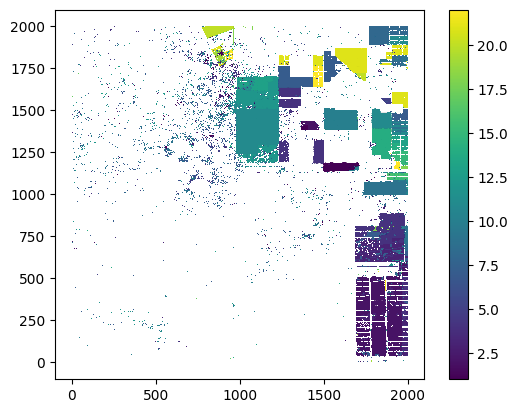

In [108]:
ax = foo.plot(column='lossyear_left', legend=True)
#ax.set_xlim(1125, 1200)
#ax.set_ylim(1250, 1300)